# Mask R-CNN - Train on Simple Baby Dataset

Modification of the Shapes Training sample.

# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class BabiesConfig(Config):
    """Configuration for training on the babies dataset.
    Derives from the base Config class and overrides values specific
    to the babies dataset.
    """
    # Give the configuration a recognizable name
    NAME = "babies"
    
    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    BACKBONE = "resnet50"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    USE_MINI_MASK = False

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 70

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    LEARNING_RATE = 0.005
    
config = BabiesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class BabiesDataset(utils.Dataset):
    """Generates the babies dataset.
    """

    def load_babies(self, count, validation=False):
        """Generate the requested number of images.
        count: number of images to generate.
        validation: whether this is validation set.
        """
        # Add classes
        self.add_class("babies", 1, "baby")
        
        image_dir = 'Images'
        if validation:
            image_dir = os.path.join(image_dir, 'Validation')
        else:
            image_dir = os.path.join(image_dir, 'Training')

        # Add images
        for i in range(count):
            image_path = os.path.join(image_dir, '{}.png'.format(i))
            image = skimage.io.imread(image_path)
            if image.shape[2] == 4:
                image = image[:,:,:3]
            
            self.add_image("babies", image_id=i, path=image_path,
                           height=image.shape[0], width=image.shape[1])

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        elif info["source"] == "babies":
            return info
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        image_path = info['path']
        validation_path = image_path.replace('.png', '.labels.tif')
        mask = skimage.io.imread(validation_path)
        mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
        class_ids = np.array([1], np.int32)
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [5]:
# Training dataset
dataset_train = BabiesDataset()
dataset_train.load_babies(28)
dataset_train.prepare()

# Validation dataset
dataset_val = BabiesDataset()
dataset_val.load_babies(5, validation=True)
dataset_val.prepare()

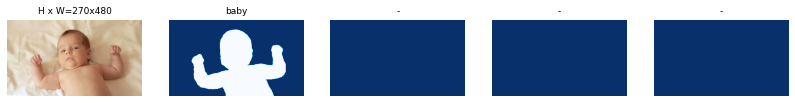

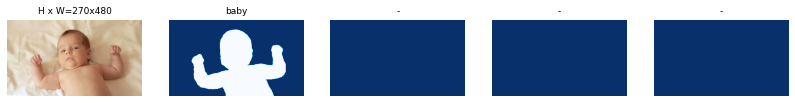

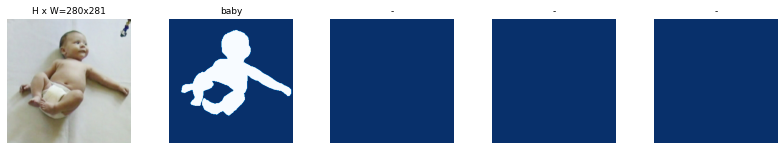

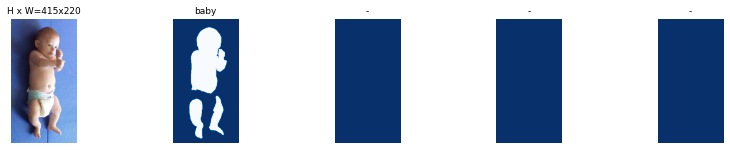

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=15, 
            layers='heads')


Starting at epoch 0. LR=0.005

Checkpoint Path: /home/svu/e0201435/Mask_RCNN/logs/babies20210224T0334/mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


70/70 [==============================] - 59s 840ms/step - loss: 1.3257 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.4042 - mrcnn_class_loss: 0.1758 - mrcnn_bbox_loss: 0.4692 - mrcnn_mask_loss: 0.2320 - val_loss: 0.8796 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.2611 - val_mrcnn_class_loss: 0.2156 - val_mrcnn_bbox_loss: 0.2507 - val_mrcnn_mask_loss: 0.1481
Epoch 2/15
13/70 [====>.........................] - ETA: 24s - loss: 0.6015 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.1067WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.148890). Check your callbacks.


47/70 [===================>..........] - ETA: 10s - loss: 0.5080 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1844 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.1006WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.148761). Check your callbacks.


70/70 [==============================] - 35s 501ms/step - loss: 0.4512 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.0965 - val_loss: 0.7206 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.2957 - val_mrcnn_class_loss: 0.1144 - val_mrcnn_bbox_loss: 0.1611 - val_mrcnn_mask_loss: 0.1470
Epoch 3/15
15/70 [=====>........................] - ETA: 23s - loss: 0.2870 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0805WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.157020). Check your callbacks.


45/70 [==================>...........] - ETA: 11s - loss: 0.2917 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0809WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.157347). Check your callbacks.


70/70 [==============================] - 36s 508ms/step - loss: 0.2734 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0786 - val_loss: 0.7223 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0.2761 - val_mrcnn_class_loss: 0.1062 - val_mrcnn_bbox_loss: 0.1724 - val_mrcnn_mask_loss: 0.1644
Epoch 4/15
11/70 [===>..........................] - ETA: 25s - loss: 0.2613 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1158 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0760WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.154783). Check your callbacks.


41/70 [================>.............] - ETA: 12s - loss: 0.2649 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0730WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.158937). Check your callbacks.


67/70 [===========================>..] - ETA: 1s - loss: 0.2471 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.0714WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.172847). Check your callbacks.


70/70 [==============================] - 34s 487ms/step - loss: 0.2454 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0710 - val_loss: 0.7518 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.2653 - val_mrcnn_class_loss: 0.1828 - val_mrcnn_bbox_loss: 0.1332 - val_mrcnn_mask_loss: 0.1678
Epoch 5/15
28/70 [===========>..................] - ETA: 21s - loss: 0.1596 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0656WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.160797). Check your callbacks.


58/70 [=======================>......] - ETA: 6s - loss: 0.1534 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0665WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.155858). Check your callbacks.


70/70 [==============================] - 38s 541ms/step - loss: 0.1497 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0660 - val_loss: 0.6820 - val_rpn_class_loss: 0.0020 - val_rpn_bbox_loss: 0.2173 - val_mrcnn_class_loss: 0.1715 - val_mrcnn_bbox_loss: 0.1136 - val_mrcnn_mask_loss: 0.1777
Epoch 6/15
19/70 [=======>......................] - ETA: 26s - loss: 0.1352 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0674WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.176015). Check your callbacks.


45/70 [==================>...........] - ETA: 12s - loss: 0.1315 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0663WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.180000). Check your callbacks.


70/70 [==============================] - 37s 530ms/step - loss: 0.1314 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0653 - val_loss: 0.6255 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.2390 - val_mrcnn_class_loss: 0.1015 - val_mrcnn_bbox_loss: 0.1176 - val_mrcnn_mask_loss: 0.1655
Epoch 7/15
 2/70 [..............................] - ETA: 24s - loss: 0.1583 - rpn_class_loss: 6.5096e-04 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0513WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.219481). Check your callbacks.


33/70 [=============>................] - ETA: 15s - loss: 0.1365 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0584WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.174643). Check your callbacks.


60/70 [========================>.....] - ETA: 4s - loss: 0.1279 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0580WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.189352). Check your callbacks.


70/70 [==============================] - 35s 501ms/step - loss: 0.1261 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0585 - val_loss: 0.6267 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 0.2323 - val_mrcnn_class_loss: 0.1032 - val_mrcnn_bbox_loss: 0.1168 - val_mrcnn_mask_loss: 0.1730
Epoch 8/15
20/70 [=======>......................] - ETA: 22s - loss: 0.1046 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0089 - mrcnn_mask_loss: 0.0572WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.171647). Check your callbacks.


48/70 [===================>..........] - ETA: 10s - loss: 0.1004 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0575WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.172924). Check your callbacks.


70/70 [==============================] - 36s 511ms/step - loss: 0.0946 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0069 - mrcnn_mask_loss: 0.0566 - val_loss: 0.6763 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.2239 - val_mrcnn_class_loss: 0.1339 - val_mrcnn_bbox_loss: 0.1436 - val_mrcnn_mask_loss: 0.1735
Epoch 9/15
10/70 [===>..........................] - ETA: 25s - loss: 0.0822 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0090 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0489WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.176520). Check your callbacks.


37/70 [==============>...............] - ETA: 15s - loss: 0.0910 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0098 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0091 - mrcnn_mask_loss: 0.0523WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.172588). Check your callbacks.


63/70 [==========================>...] - ETA: 3s - loss: 0.0961 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0108 - mrcnn_mask_loss: 0.0523WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.176956). Check your callbacks.


70/70 [==============================] - 36s 517ms/step - loss: 0.0945 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0105 - mrcnn_mask_loss: 0.0523 - val_loss: 0.6772 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 0.2119 - val_mrcnn_class_loss: 0.1547 - val_mrcnn_bbox_loss: 0.1316 - val_mrcnn_mask_loss: 0.1777
Epoch 10/15
24/70 [=========>....................] - ETA: 25s - loss: 0.0902 - rpn_class_loss: 9.2764e-04 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0504WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.179750). Check your callbacks.


51/70 [====================>.........] - ETA: 10s - loss: 0.0973 - rpn_class_loss: 9.5609e-04 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.0533WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.182112). Check your callbacks.


70/70 [==============================] - 41s 591ms/step - loss: 0.0954 - rpn_class_loss: 9.4316e-04 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0098 - mrcnn_mask_loss: 0.0529 - val_loss: 0.7455 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.2362 - val_mrcnn_class_loss: 0.1982 - val_mrcnn_bbox_loss: 0.1149 - val_mrcnn_mask_loss: 0.1945
Epoch 11/15
11/70 [===>..........................] - ETA: 26s - loss: 0.0797 - rpn_class_loss: 7.2899e-04 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0545WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.184078). Check your callbacks.


38/70 [===============>..............] - ETA: 14s - loss: 0.0738 - rpn_class_loss: 7.8963e-04 - rpn_bbox_loss: 0.0087 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0521WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.182496). Check your callbacks.


65/70 [==========================>...] - ETA: 2s - loss: 0.0711 - rpn_class_loss: 7.9461e-04 - rpn_bbox_loss: 0.0074 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0491WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.184028). Check your callbacks.


70/70 [==============================] - 37s 532ms/step - loss: 0.0715 - rpn_class_loss: 8.3526e-04 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0490 - val_loss: 0.7297 - val_rpn_class_loss: 9.7759e-04 - val_rpn_bbox_loss: 0.2128 - val_mrcnn_class_loss: 0.1994 - val_mrcnn_bbox_loss: 0.1023 - val_mrcnn_mask_loss: 0.2142
Epoch 12/15
26/70 [==========>...................] - ETA: 22s - loss: 0.0623 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.0490WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.179188). Check your callbacks.


52/70 [=====================>........] - ETA: 9s - loss: 0.0739 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0490WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.183327). Check your callbacks.


70/70 [==============================] - 39s 556ms/step - loss: 0.0789 - rpn_class_loss: 9.8242e-04 - rpn_bbox_loss: 0.0089 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0082 - mrcnn_mask_loss: 0.0499 - val_loss: 0.7107 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.2475 - val_mrcnn_class_loss: 0.1219 - val_mrcnn_bbox_loss: 0.1527 - val_mrcnn_mask_loss: 0.1875
Epoch 13/15
13/70 [====>.........................] - ETA: 26s - loss: 0.0968 - rpn_class_loss: 7.4639e-04 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.0103 - mrcnn_mask_loss: 0.0563WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.190274). Check your callbacks.


40/70 [================>.............] - ETA: 14s - loss: 0.0891 - rpn_class_loss: 7.8220e-04 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0102 - mrcnn_mask_loss: 0.0536WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.187722). Check your callbacks.


66/70 [===========================>..] - ETA: 1s - loss: 0.0903 - rpn_class_loss: 7.8953e-04 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0097 - mrcnn_mask_loss: 0.0522WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.187120). Check your callbacks.


70/70 [==============================] - 36s 517ms/step - loss: 0.0895 - rpn_class_loss: 7.8912e-04 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.0522 - val_loss: 0.6937 - val_rpn_class_loss: 9.1135e-04 - val_rpn_bbox_loss: 0.2447 - val_mrcnn_class_loss: 0.1231 - val_mrcnn_bbox_loss: 0.1187 - val_mrcnn_mask_loss: 0.2062
Epoch 14/15
27/70 [==========>...................] - ETA: 20s - loss: 0.0697 - rpn_class_loss: 8.6702e-04 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0474WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.186743). Check your callbacks.


54/70 [======================>.......] - ETA: 8s - loss: 0.0638 - rpn_class_loss: 8.7683e-04 - rpn_bbox_loss: 0.0084 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.0448WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.193574). Check your callbacks.


70/70 [==============================] - 38s 544ms/step - loss: 0.0625 - rpn_class_loss: 8.1692e-04 - rpn_bbox_loss: 0.0074 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.0447 - val_loss: 0.6613 - val_rpn_class_loss: 9.7919e-04 - val_rpn_bbox_loss: 0.2372 - val_mrcnn_class_loss: 0.0972 - val_mrcnn_bbox_loss: 0.1024 - val_mrcnn_mask_loss: 0.2235
Epoch 15/15
15/70 [=====>........................] - ETA: 28s - loss: 0.0518 - rpn_class_loss: 8.0240e-04 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0408WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.190782). Check your callbacks.


41/70 [================>.............] - ETA: 14s - loss: 0.0463 - rpn_class_loss: 7.0191e-04 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.0373WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.191862). Check your callbacks.


68/70 [============================>.] - ETA: 1s - loss: 0.0438 - rpn_class_loss: 6.6637e-04 - rpn_bbox_loss: 0.0027 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.0364WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.194419). Check your callbacks.


70/70 [==============================] - 39s 558ms/step - loss: 0.0436 - rpn_class_loss: 6.6784e-04 - rpn_bbox_loss: 0.0027 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.0364 - val_loss: 0.6077 - val_rpn_class_loss: 8.5913e-04 - val_rpn_bbox_loss: 0.2125 - val_mrcnn_class_loss: 0.0713 - val_mrcnn_bbox_loss: 0.0824 - val_mrcnn_mask_loss: 0.2407


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 40,
            epochs=8, 
            layers="all")


Starting at epoch 15. LR=0.000125

Checkpoint Path: /home/svu/e0201435/Mask_RCNN/logs/babies20210224T0334/mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(BabiesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/svu/e0201435/Mask_RCNN/logs/babies20210224T0334/mask_rcnn_babies_0015.h5
Re-starting from epoch 15


original_image           shape: (256, 256, 3)         min:    0.00000  max:  251.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   20.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


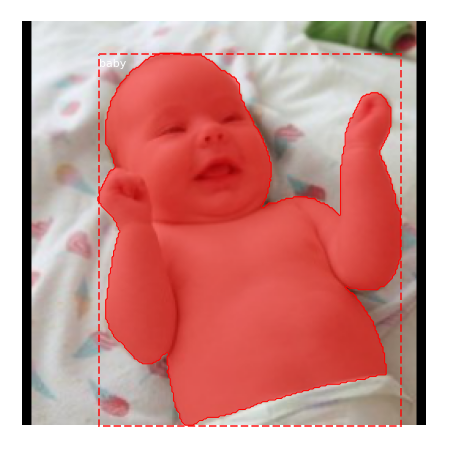

In [13]:
# Test on a training image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


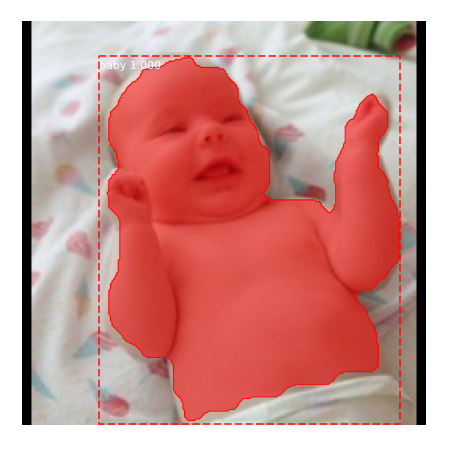

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  275.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   51.00000  max:  193.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


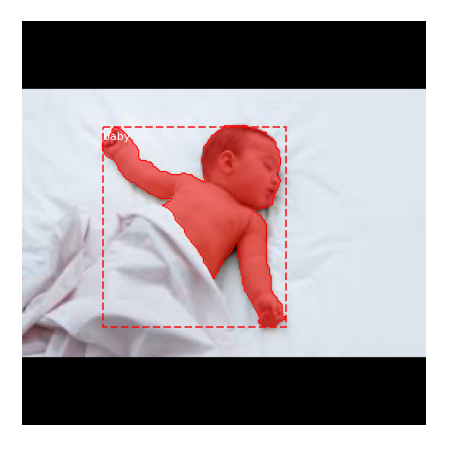

In [15]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


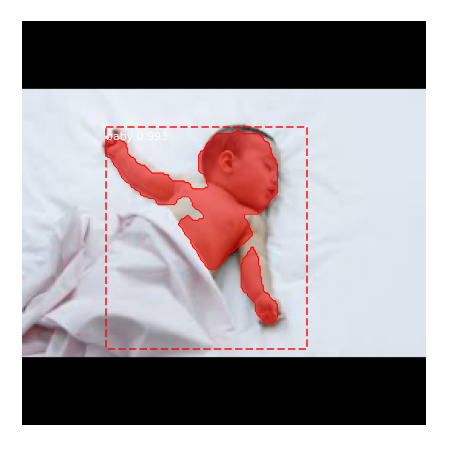

In [16]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [17]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
